<a href="https://colab.research.google.com/github/axellevandeneynde/fml-assignment-week-1-3/blob/main/week1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We are going to explore data from activity trackers. Activity trackers are applications that track your activity using your smartphone, a smartwatch, wrist band or a clip-on device. Popular applications include Steps (iPhone), Apple Watch, Fitbit and Jawbone. For a study in France, over 900 volunteers received a Fitbit Zip (a clip-on activity tracker) and recorded their daily steps, distance and calories.

In [45]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt 
import math
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

The data were simulated from the actual data to conform to the GDPR law.

In [3]:
dfSteps = pd.read_csv('steps.csv', sep=';')
dfSteps.head()

,id,20-6-2013,21-6-2013,22-6-2013,23-6-2013,24-6-2013,25-6-2013,26-6-2013,27-6-2013,28-6-2013,29-6-2013,30-6-2013,1-7-2013,2-7-2013,3-7-2013,4-7-2013,5-7-2013,6-7-2013,7-7-2013,8-7-2013,9-7-2013,10-7-2013,11-7-2013,12-7-2013,13-7-2013,14-7-2013,15-7-2013,16-7-2013,17-7-2013,18-7-2013,19-7-2013,20-7-2013,21-7-2013,22-7-2013,23-7-2013,24-7-2013,25-7-2013,26-7-2013,27-7-2013,28-7-2013,...,4-4-2014,5-4-2014,6-4-2014,7-4-2014,8-4-2014,9-4-2014,10-4-2014,11-4-2014,12-4-2014,13-4-2014,14-4-2014,15-4-2014,16-4-2014,17-4-2014,18-4-2014,19-4-2014,20-4-2014,21-4-2014,22-4-2014,23-4-2014,24-4-2014,25-4-2014,26-4-2014,27-4-2014,28-4-2014,29-4-2014,30-4-2014,1-5-2014,2-5-2014,3-5-2014,4-5-2014,5-5-2014,6-5-2014,7-5-2014,8-5-2014,9-5-2014,10-5-2014,11-5-2014,12-5-2014,13-5-2014
0,1,NaN,NaN,NaN,NaN,3941.0,15733.0,9929.0,12879.0,10541.0,15773.0,2795.0,10798.0,13885.0,9654.0,19481.0,8518.0,9385.0,30580.0,15490.0,5708.0,11983.0,14228.0,12205.0,14410.0,8667.0,NaN,10616.0,13538.0,12254.0,NaN,10410.0,9617.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,10473.0,705.0,4287.0,5507.0,4024.0,3926.0,14595.0,2952.0,4839.0,6181.0,6926.0,6589.0,8839.0,1370.0,5092.0,2589.0,8019.0,6712.0,2385.0,565.0,7369.0,4515.0,702.0,5320.0,5374.0,4234.0,3235.0,15960.0,38.0,1719.0,2005.0,7657.0,2001.0,4428.0,144.0,32.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,11428.0,12523.0,2553.0,190.0,2164.0,8185.0,9630.0,8983.0,5700.0,3998.0,12073.0,23039.0,7650.0,9561.0,11100.0,7278.0,9523.0,10140.0,13779.0,13643.0,6861.0,12567.0,7108.0,10534.0,5490.0,11437.0,NaN,12287.0,8129.0,NaN,NaN,14498.0,NaN,9826.0,10453.0,11263.0,NaN,12592.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1113.0,NaN,1275.0,8255.0,3914.0,4364.0,NaN,NaN,NaN,6227.0,4567.0,2567.0,1129.0,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,3290.0,5297.0,6443.0,11396.0,2290.0,3737.0,3875.0,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5816.0,NaN,NaN,NaN,NaN,897.0,4492.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1198.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5988.0,2338.0,223.0,633.0,202.0,18392.0,6373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1319.0,1198.0,NaN,2433.0,NaN,NaN,NaN,3173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dfSurvey = pd.read_csv('survey.csv', sep=',')
dfSurvey.head()

,id,city,gender,age,hh_size,education,education_1,height,weight
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0


# Data cleaning

## Merge datasets

Merging on identifier variable 'id'

In [5]:
df = pd.merge(dfSurvey, dfSteps, on='id')
df.head()

,id,city,gender,age,hh_size,education,education_1,height,weight,20-6-2013,21-6-2013,22-6-2013,23-6-2013,24-6-2013,25-6-2013,26-6-2013,27-6-2013,28-6-2013,29-6-2013,30-6-2013,1-7-2013,2-7-2013,3-7-2013,4-7-2013,5-7-2013,6-7-2013,7-7-2013,8-7-2013,9-7-2013,10-7-2013,11-7-2013,12-7-2013,13-7-2013,14-7-2013,15-7-2013,16-7-2013,17-7-2013,18-7-2013,19-7-2013,20-7-2013,...,4-4-2014,5-4-2014,6-4-2014,7-4-2014,8-4-2014,9-4-2014,10-4-2014,11-4-2014,12-4-2014,13-4-2014,14-4-2014,15-4-2014,16-4-2014,17-4-2014,18-4-2014,19-4-2014,20-4-2014,21-4-2014,22-4-2014,23-4-2014,24-4-2014,25-4-2014,26-4-2014,27-4-2014,28-4-2014,29-4-2014,30-4-2014,1-5-2014,2-5-2014,3-5-2014,4-5-2014,5-5-2014,6-5-2014,7-5-2014,8-5-2014,9-5-2014,10-5-2014,11-5-2014,12-5-2014,13-5-2014
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0,NaN,NaN,NaN,NaN,3941.0,15733.0,9929.0,12879.0,10541.0,15773.0,2795.0,10798.0,13885.0,9654.0,19481.0,8518.0,9385.0,30580.0,15490.0,5708.0,11983.0,14228.0,12205.0,14410.0,8667.0,NaN,10616.0,13538.0,12254.0,NaN,10410.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0,NaN,NaN,10473.0,705.0,4287.0,5507.0,4024.0,3926.0,14595.0,2952.0,4839.0,6181.0,6926.0,6589.0,8839.0,1370.0,5092.0,2589.0,8019.0,6712.0,2385.0,565.0,7369.0,4515.0,702.0,5320.0,5374.0,4234.0,3235.0,15960.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0,NaN,11428.0,12523.0,2553.0,190.0,2164.0,8185.0,9630.0,8983.0,5700.0,3998.0,12073.0,23039.0,7650.0,9561.0,11100.0,7278.0,9523.0,10140.0,13779.0,13643.0,6861.0,12567.0,7108.0,10534.0,5490.0,11437.0,NaN,12287.0,8129.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1113.0,NaN,1275.0,8255.0,3914.0,4364.0,NaN,NaN,NaN,6227.0,4567.0,2567.0,1129.0,NaN
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,3290.0,5297.0,6443.0,11396.0,2290.0,3737.0,3875.0,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5816.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1198.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5988.0,2338.0,223.0,633.0,202.0,18392.0,6373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1319.0,1198.0,NaN,2433.0,NaN,NaN,NaN,3173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Remove impossible values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 0 to 928
Columns: 337 entries, id to 13-5-2014
dtypes: float64(330), int64(3), object(4)
memory usage: 2.4+ MB


Using value_counts() to have a quick overview of used values to see if they are all valid

In [7]:
df['city'].value_counts()

Lille          505
Montpellier    153
Lyon           142
Bordeaux       129
Name: city, dtype: int64

In [8]:
df['gender'].value_counts()

Male      494
Female    435
Name: gender, dtype: int64

In [9]:
df['age'].value_counts()

25-34    426
35-44    178
45-54    147
<25      125
55-64     46
65+        7
Name: age, dtype: int64

In [10]:
df['hh_size'].value_counts()

2     355
1     252
3     141
4     125
5      50
6       5
11      1
Name: hh_size, dtype: int64

In [11]:
df['education'].value_counts()

2    333
4    287
1    234
5     39
3     36
Name: education, dtype: int64

In [12]:
df['education_1'].value_counts()

Master or doctorate    412
Bachelor               357
High school            106
Vocational              40
Primary                 13
No degree                1
Name: education_1, dtype: int64

For variabes having to many different values, using displot to have a quick overview for impossible data

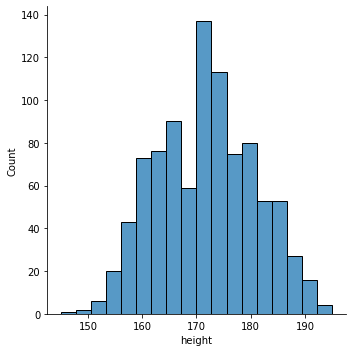

In [13]:
sns.displot(df['height']) 
plt.show()

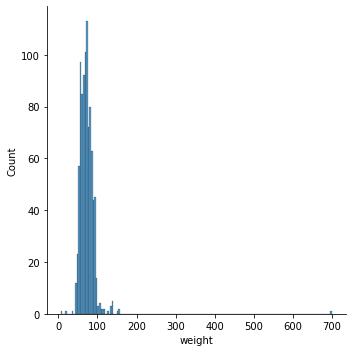

In [14]:
sns.displot(df['weight']) 
plt.show()

The outlier at almost 700kg is not impossible. Based on recording of people wheiging well above 600kg and reports of people weighing above 700kg. ([wikipedia](https://en.wikipedia.org/wiki/List_of_heaviest_people))

With the minimum height of the dataset being above 140cm I decided to remove weights of less than 15kg. This is a lower estimate of the minimum possible weight as I couldn't immediatly find a source to back it up. 

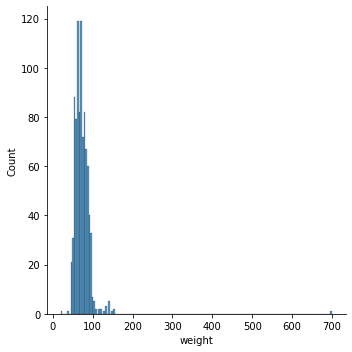

In [15]:
rowsNotMinimumWeight = df[df['weight'] <= 15].index
df.drop(rowsNotMinimumWeight , inplace=True)
sns.displot(df['weight']) 
plt.show()

Checking if no impossibly high steps per day were saved

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928 entries, 0 to 928
Columns: 337 entries, id to 13-5-2014
dtypes: float64(330), int64(3), object(4)
memory usage: 2.4+ MB


In [17]:
max = df.loc[:, '20-6-2013':'13-5-2014'].max()
max.max()

999999.0

Remove the impossible value

In [18]:
dfSteps = df.loc[:, '20-6-2013':'13-5-2014']
indexesToremove = []

for columnName in list(dfSteps):
  indexesToremove.extend(df[df[columnName] == 999999].index)

indexesToremove = list(set(indexesToremove))
df = df.drop(indexesToremove)

max = df.loc[:, '20-6-2013':'13-5-2014'].max()
max.max()


91623.0

## Mean steps per participant

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915 entries, 0 to 928
Columns: 337 entries, id to 13-5-2014
dtypes: float64(330), int64(3), object(4)
memory usage: 2.4+ MB


In [20]:
mean = df.loc[:, '20-6-2013':'13-5-2014'].mean(axis=1,  numeric_only=True)
mean.head()

0    10205.521212
1     5687.423313
2     8301.729730
3     3633.200000
4     5312.129630
dtype: float64

In [21]:
df = df.assign(mean_steps=mean)
df.head()

,id,city,gender,age,hh_size,education,education_1,height,weight,20-6-2013,21-6-2013,22-6-2013,23-6-2013,24-6-2013,25-6-2013,26-6-2013,27-6-2013,28-6-2013,29-6-2013,30-6-2013,1-7-2013,2-7-2013,3-7-2013,4-7-2013,5-7-2013,6-7-2013,7-7-2013,8-7-2013,9-7-2013,10-7-2013,11-7-2013,12-7-2013,13-7-2013,14-7-2013,15-7-2013,16-7-2013,17-7-2013,18-7-2013,19-7-2013,20-7-2013,...,5-4-2014,6-4-2014,7-4-2014,8-4-2014,9-4-2014,10-4-2014,11-4-2014,12-4-2014,13-4-2014,14-4-2014,15-4-2014,16-4-2014,17-4-2014,18-4-2014,19-4-2014,20-4-2014,21-4-2014,22-4-2014,23-4-2014,24-4-2014,25-4-2014,26-4-2014,27-4-2014,28-4-2014,29-4-2014,30-4-2014,1-5-2014,2-5-2014,3-5-2014,4-5-2014,5-5-2014,6-5-2014,7-5-2014,8-5-2014,9-5-2014,10-5-2014,11-5-2014,12-5-2014,13-5-2014,mean_steps
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0,NaN,NaN,NaN,NaN,3941.0,15733.0,9929.0,12879.0,10541.0,15773.0,2795.0,10798.0,13885.0,9654.0,19481.0,8518.0,9385.0,30580.0,15490.0,5708.0,11983.0,14228.0,12205.0,14410.0,8667.0,NaN,10616.0,13538.0,12254.0,NaN,10410.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10205.521212
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0,NaN,NaN,10473.0,705.0,4287.0,5507.0,4024.0,3926.0,14595.0,2952.0,4839.0,6181.0,6926.0,6589.0,8839.0,1370.0,5092.0,2589.0,8019.0,6712.0,2385.0,565.0,7369.0,4515.0,702.0,5320.0,5374.0,4234.0,3235.0,15960.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5687.423313
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0,NaN,11428.0,12523.0,2553.0,190.0,2164.0,8185.0,9630.0,8983.0,5700.0,3998.0,12073.0,23039.0,7650.0,9561.0,11100.0,7278.0,9523.0,10140.0,13779.0,13643.0,6861.0,12567.0,7108.0,10534.0,5490.0,11437.0,NaN,12287.0,8129.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1113.0,NaN,1275.0,8255.0,3914.0,4364.0,NaN,NaN,NaN,6227.0,4567.0,2567.0,1129.0,NaN,8301.729730
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,3290.0,5297.0,6443.0,11396.0,2290.0,3737.0,3875.0,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5816.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1198.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3633.200000
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2338.0,223.0,633.0,202.0,18392.0,6373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1319.0,1198.0,NaN,2433.0,NaN,NaN,NaN,3173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5312.129630


# Feature Engineering

Calculating BMI for each participant, as it gives a better indication for participants having a healthy weight.

In [22]:
bmi = (df['weight'] / df['height']/ df['height']) * 10000
bmi = bmi.tolist()
df = df.assign(bmi = bmi)
df.head()

,id,city,gender,age,hh_size,education,education_1,height,weight,20-6-2013,21-6-2013,22-6-2013,23-6-2013,24-6-2013,25-6-2013,26-6-2013,27-6-2013,28-6-2013,29-6-2013,30-6-2013,1-7-2013,2-7-2013,3-7-2013,4-7-2013,5-7-2013,6-7-2013,7-7-2013,8-7-2013,9-7-2013,10-7-2013,11-7-2013,12-7-2013,13-7-2013,14-7-2013,15-7-2013,16-7-2013,17-7-2013,18-7-2013,19-7-2013,20-7-2013,...,6-4-2014,7-4-2014,8-4-2014,9-4-2014,10-4-2014,11-4-2014,12-4-2014,13-4-2014,14-4-2014,15-4-2014,16-4-2014,17-4-2014,18-4-2014,19-4-2014,20-4-2014,21-4-2014,22-4-2014,23-4-2014,24-4-2014,25-4-2014,26-4-2014,27-4-2014,28-4-2014,29-4-2014,30-4-2014,1-5-2014,2-5-2014,3-5-2014,4-5-2014,5-5-2014,6-5-2014,7-5-2014,8-5-2014,9-5-2014,10-5-2014,11-5-2014,12-5-2014,13-5-2014,mean_steps,bmi
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0,NaN,NaN,NaN,NaN,3941.0,15733.0,9929.0,12879.0,10541.0,15773.0,2795.0,10798.0,13885.0,9654.0,19481.0,8518.0,9385.0,30580.0,15490.0,5708.0,11983.0,14228.0,12205.0,14410.0,8667.0,NaN,10616.0,13538.0,12254.0,NaN,10410.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10205.521212,30.930438
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0,NaN,NaN,10473.0,705.0,4287.0,5507.0,4024.0,3926.0,14595.0,2952.0,4839.0,6181.0,6926.0,6589.0,8839.0,1370.0,5092.0,2589.0,8019.0,6712.0,2385.0,565.0,7369.0,4515.0,702.0,5320.0,5374.0,4234.0,3235.0,15960.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5687.423313,23.765432
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0,NaN,11428.0,12523.0,2553.0,190.0,2164.0,8185.0,9630.0,8983.0,5700.0,3998.0,12073.0,23039.0,7650.0,9561.0,11100.0,7278.0,9523.0,10140.0,13779.0,13643.0,6861.0,12567.0,7108.0,10534.0,5490.0,11437.0,NaN,12287.0,8129.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1113.0,NaN,1275.0,8255.0,3914.0,4364.0,NaN,NaN,NaN,6227.0,4567.0,2567.0,1129.0,NaN,8301.729730,25.617284
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,3290.0,5297.0,6443.0,11396.0,2290.0,3737.0,3875.0,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5816.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1198.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3633.200000,25.249337
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,223.0,633.0,202.0,18392.0,6373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1319.0,1198.0,NaN,2433.0,NaN,NaN,NaN,3173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5312.129630,21.872423


# Exploratory data analysis

## Mean steps per participant


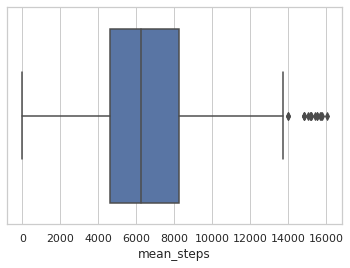

In [23]:
sns.set_theme(style="whitegrid")
sns.boxplot(x=df['mean_steps']) 
plt.show()

In [24]:
print(df['mean_steps'].describe())

count      911.000000
mean      6603.308042
std       2772.168538
min          4.000000
25%       4623.733333
50%       6224.000000
75%       8266.256927
max      16026.470238
Name: mean_steps, dtype: float64


The mean steps distribution is normal and slightly right-skewed, with a relatively short tail.

**In relation with gender:**



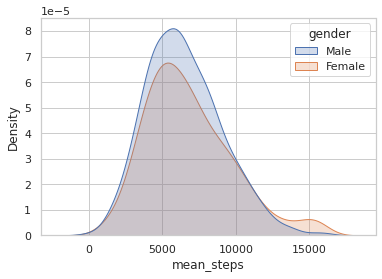

In [25]:
sns.kdeplot(data=df, x="mean_steps", hue='gender', fill=True)
plt.show()

### In relation with age and gender:

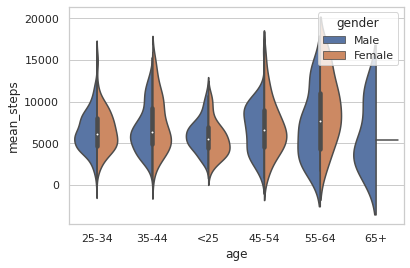

In [26]:
sns.set_theme(style="whitegrid")
sns.violinplot(data=df, y='mean_steps', x='age', hue='gender', split=True)
plt.show()

The distribution varries depending on the age group. How older the age group, how wider the distribution becomes. 

## Correlations

In [27]:
df.head()

,id,city,gender,age,hh_size,education,education_1,height,weight,20-6-2013,21-6-2013,22-6-2013,23-6-2013,24-6-2013,25-6-2013,26-6-2013,27-6-2013,28-6-2013,29-6-2013,30-6-2013,1-7-2013,2-7-2013,3-7-2013,4-7-2013,5-7-2013,6-7-2013,7-7-2013,8-7-2013,9-7-2013,10-7-2013,11-7-2013,12-7-2013,13-7-2013,14-7-2013,15-7-2013,16-7-2013,17-7-2013,18-7-2013,19-7-2013,20-7-2013,...,6-4-2014,7-4-2014,8-4-2014,9-4-2014,10-4-2014,11-4-2014,12-4-2014,13-4-2014,14-4-2014,15-4-2014,16-4-2014,17-4-2014,18-4-2014,19-4-2014,20-4-2014,21-4-2014,22-4-2014,23-4-2014,24-4-2014,25-4-2014,26-4-2014,27-4-2014,28-4-2014,29-4-2014,30-4-2014,1-5-2014,2-5-2014,3-5-2014,4-5-2014,5-5-2014,6-5-2014,7-5-2014,8-5-2014,9-5-2014,10-5-2014,11-5-2014,12-5-2014,13-5-2014,mean_steps,bmi
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0,NaN,NaN,NaN,NaN,3941.0,15733.0,9929.0,12879.0,10541.0,15773.0,2795.0,10798.0,13885.0,9654.0,19481.0,8518.0,9385.0,30580.0,15490.0,5708.0,11983.0,14228.0,12205.0,14410.0,8667.0,NaN,10616.0,13538.0,12254.0,NaN,10410.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10205.521212,30.930438
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0,NaN,NaN,10473.0,705.0,4287.0,5507.0,4024.0,3926.0,14595.0,2952.0,4839.0,6181.0,6926.0,6589.0,8839.0,1370.0,5092.0,2589.0,8019.0,6712.0,2385.0,565.0,7369.0,4515.0,702.0,5320.0,5374.0,4234.0,3235.0,15960.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5687.423313,23.765432
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0,NaN,11428.0,12523.0,2553.0,190.0,2164.0,8185.0,9630.0,8983.0,5700.0,3998.0,12073.0,23039.0,7650.0,9561.0,11100.0,7278.0,9523.0,10140.0,13779.0,13643.0,6861.0,12567.0,7108.0,10534.0,5490.0,11437.0,NaN,12287.0,8129.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1113.0,NaN,1275.0,8255.0,3914.0,4364.0,NaN,NaN,NaN,6227.0,4567.0,2567.0,1129.0,NaN,8301.729730,25.617284
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,3290.0,5297.0,6443.0,11396.0,2290.0,3737.0,3875.0,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5816.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1198.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3633.200000,25.249337
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,223.0,633.0,202.0,18392.0,6373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1319.0,1198.0,NaN,2433.0,NaN,NaN,NaN,3173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5312.129630,21.872423


Only keeping numerical values

In [28]:
dfNumeric = df.loc[:,['hh_size', 'education', 'height', 'weight', 'bmi', 'mean_steps']]
dfNumeric.head()

,hh_size,education,height,weight,bmi,mean_steps
0,4,4,178.0,98.0,30.930438,10205.521212
1,1,3,180.0,77.0,23.765432,5687.423313
2,2,2,180.0,83.0,25.617284,8301.729730
3,1,1,178.0,80.0,25.249337,3633.200000
4,3,4,167.0,61.0,21.872423,5312.129630


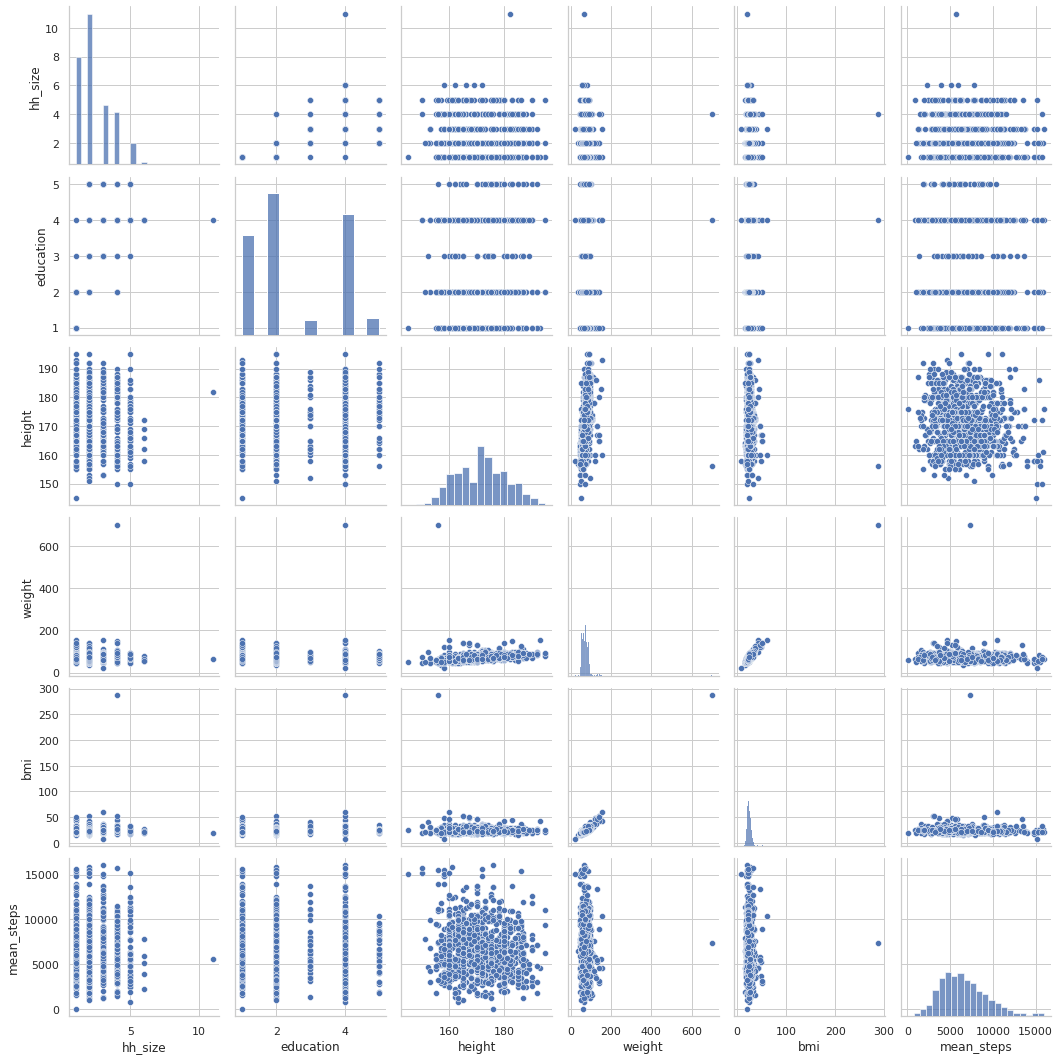

In [29]:
sns.pairplot(dfNumeric)
plt.show()

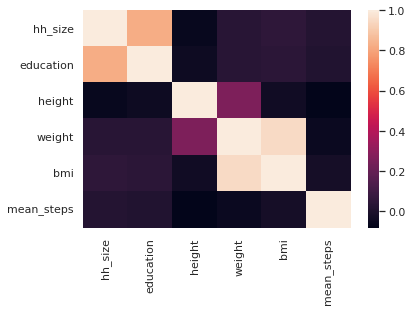

In [30]:
corr = dfNumeric.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns) #the last two arguments set the column names
plt.show()

No real correlation between mean steaps and other variables. Correlation between variables like height and weight are not relevant to the researched case.

# Predictive model

## dummy variables

Creating dummy variables from categorical variables for usability in linear regression model. 

In [31]:
education_1_dummies = pd.get_dummies(df['education_1'])
df = pd.concat([df, education_1_dummies], axis=1) 

age_dummies = pd.get_dummies(df['age'])
df = pd.concat([df, age_dummies], axis=1) 

gender_dummies = pd.get_dummies(df['gender'])
df = pd.concat([df, gender_dummies], axis=1) 

df.drop(df.loc[:,'20-6-2013':'13-5-2014'], inplace=True, axis=1) #remove steps by date
df

,id,city,gender,age,hh_size,education,education_1,height,weight,mean_steps,bmi,Bachelor,High school,Master or doctorate,No degree,Primary,Vocational,25-34,35-44,45-54,55-64,65+,<25,Female,Male
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0,10205.521212,30.930438,0,0,1,0,0,0,1,0,0,0,0,0,0,1
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0,5687.423313,23.765432,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0,8301.729730,25.617284,0,0,1,0,0,0,1,0,0,0,0,0,0,1
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0,3633.200000,25.249337,1,0,0,0,0,0,0,0,0,0,0,1,0,1
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0,5312.129630,21.872423,1,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,925,Lille,Female,45-54,3,4,Master or doctorate,165.0,59.0,6282.131868,21.671258,0,0,1,0,0,0,0,0,1,0,0,0,1,0
925,926,Lille,Male,<25,3,5,Bachelor,192.0,90.0,4799.880000,24.414062,1,0,0,0,0,0,0,0,0,0,0,1,0,1
926,927,Montpellier,Male,35-44,2,2,Bachelor,181.0,71.0,10030.326829,21.672110,1,0,0,0,0,0,0,1,0,0,0,0,0,1
927,928,Lille,Female,55-64,1,1,High school,172.0,65.0,15679.679012,21.971336,0,1,0,0,0,0,0,0,0,1,0,0,1,0


Now we can also see correlation with age, education and gender

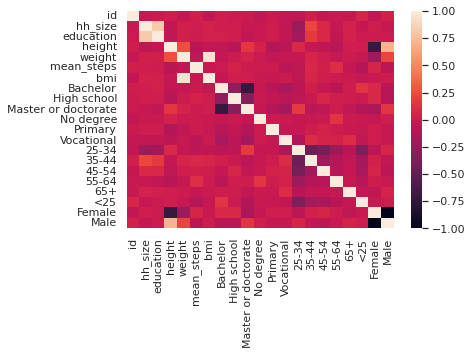

In [33]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns) #the last two arguments set the column names
plt.show()

In [35]:
corr["mean_steps"]

id                     0.035040
hh_size                0.021525
education              0.009782
height                -0.083563
weight                -0.049763
mean_steps             1.000000
bmi                   -0.020499
Bachelor              -0.005185
High school            0.051672
Master or doctorate    0.001314
No degree              0.002794
Primary                0.007479
Vocational            -0.076439
25-34                 -0.056367
35-44                  0.082141
45-54                  0.032483
55-64                  0.116302
65+                   -0.024624
<25                   -0.114683
Female                 0.063027
Male                  -0.063027
Name: mean_steps, dtype: float64

Some very weak correlations are showing up. with the 'strongest' being age categories <25 and 55-64

## Model
Variables are selected on criterion (absolute) *r* > 0.05.

Which means these are included:

* height
* weight
* education
* age
* gender

reference category is 35-44, No degree, Female. So this will be left out.

In [39]:
df = df.dropna()
y = df['mean_steps']
X = df[['height', 'weight', 'Bachelor', 'High school', 'Master or doctorate','Vocational','Primary','<25', '25-34', '45-54', '55-64', '65+', 'Male']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

lm = LinearRegression() 
model = lm.fit(X_train, y_train) 
y_test_p = lm.predict(X_test) 
X_train.head() 

,height,weight,Bachelor,High school,Master or doctorate,Vocational,Primary,<25,25-34,45-54,55-64,65+,Male
165,163.0,54.0,0,0,1,0,0,0,1,0,0,0,0
664,170.0,77.0,0,0,1,0,0,0,1,0,0,0,1
562,169.0,63.0,0,0,1,0,0,0,1,0,0,0,1
922,170.0,65.0,0,0,1,0,0,0,0,0,0,0,1
915,160.0,72.0,0,1,0,0,0,0,0,0,0,0,0


## Evaluation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


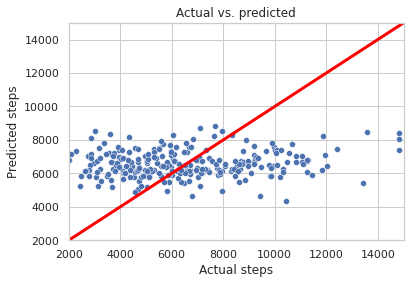

In [40]:
sns.scatterplot(y_test, y_test_p)
plt.xlabel('Actual steps')
plt.ylabel('Predicted steps')
plt.title('Actual vs. predicted')
plt.xlim([2000,15000]) #Forcing the x- and y-axis to be the same length, so that we can compare 
plt.ylim([2000,15000])
plt.plot([2000, 15000], [2000, 15000], color='red', lw=3) #Plot a diagonal length
plt.show()

This is not a good model. The dots do not follow the diagonal line. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


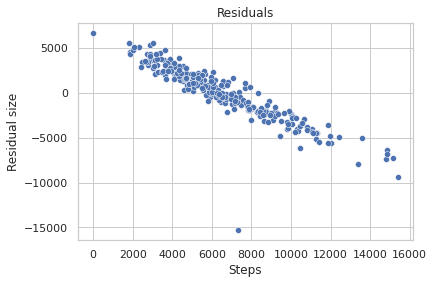

In [41]:
resid = y_test_p - y_test
sns.scatterplot(y_test, resid)
plt.title('Residuals')
plt.xlabel('Steps')
plt.ylabel('Residual size')
plt.show()

Residuals should be as close as possible to zero. which is not the case here. 

In [43]:
r2_score(y_test, y_test_p)

-0.11575291579668012

The model is able to predict 11% of the variation. This very low. 

In [46]:
math.sqrt(mean_squared_error(y_test, y_test_p))

2935.7653845549253

The model is on average wrong by 2935 steps.

# Conclusion

There is a very low corrolation between the variables and mean steps. I still tried to predict the mean-steps from these variables with linear regression. This did not succeed. 